In [11]:
import pandas as pd
df = pd.read_csv('tw_train.csv')
df


,交易日,交易別,股票代號,股票名稱,股數,單價,進帳/出帳,Unnamed: 7,XIRR,總成本(賣-買),總價值(現值+配息),總獲利(%),總配息
0,2021/01/11,買,0050,NaN,130.0,131.90,-17147,NaN,23.39%,-448141.0,719607.0,60.576024,28842.0
1,2021/01/15,買,2330,台積,20.0,612.00,-12240,NaN,NaN,NaN,NaN,NaN,NaN
2,2021/01/20,買,2376,技嘉,40.0,79.50,-3180,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/01/25,買,2330,台積,5.0,644.00,-3220,NaN,NaN,NaN,NaN,NaN,NaN
4,2021/01/29,買,2330,NaN,5.0,603.00,-3015,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024/11/29,買,00631L,NaN,10.0,222.75,-2227,NaN,NaN,NaN,NaN,NaN,NaN
140,2025/01/13,買,006208,NaN,30.0,114.70,-3445,NaN,NaN,NaN,NaN,NaN,NaN
141,2025/01/15,買,006208,NaN,20.0,113.25,-2268,NaN,NaN,NaN,NaN,NaN,NaN
142,2025/01/15,買,00631L,NaN,10.0,232.55,-2328,NaN,NaN,NaN,NaN,NaN,NaN


[*********************100%%**********************]  1 of 1 completed


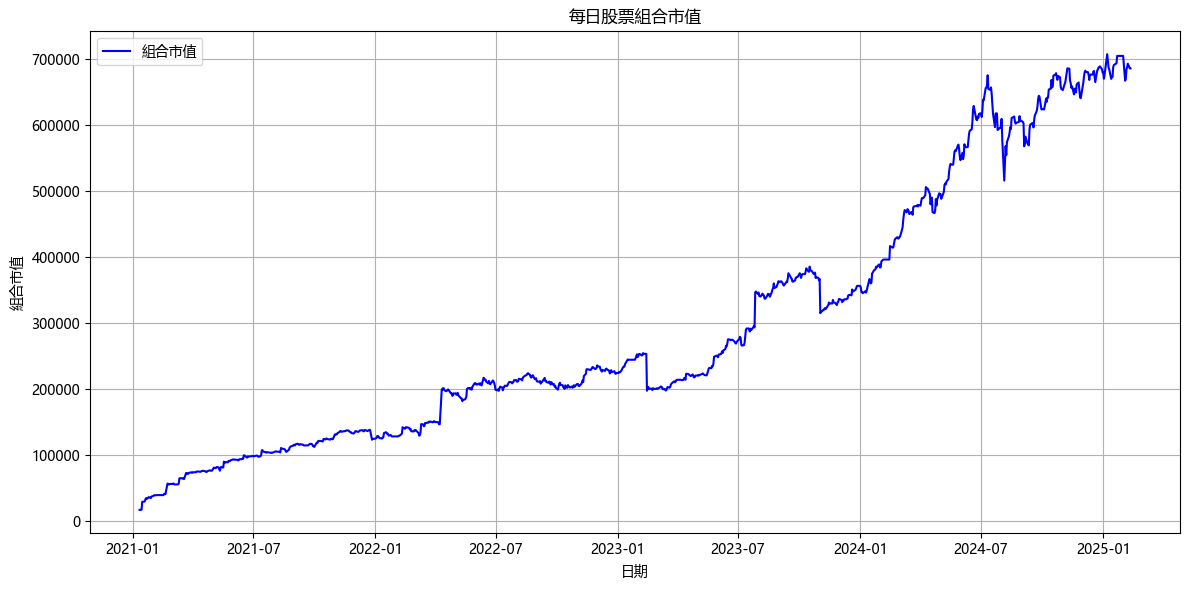

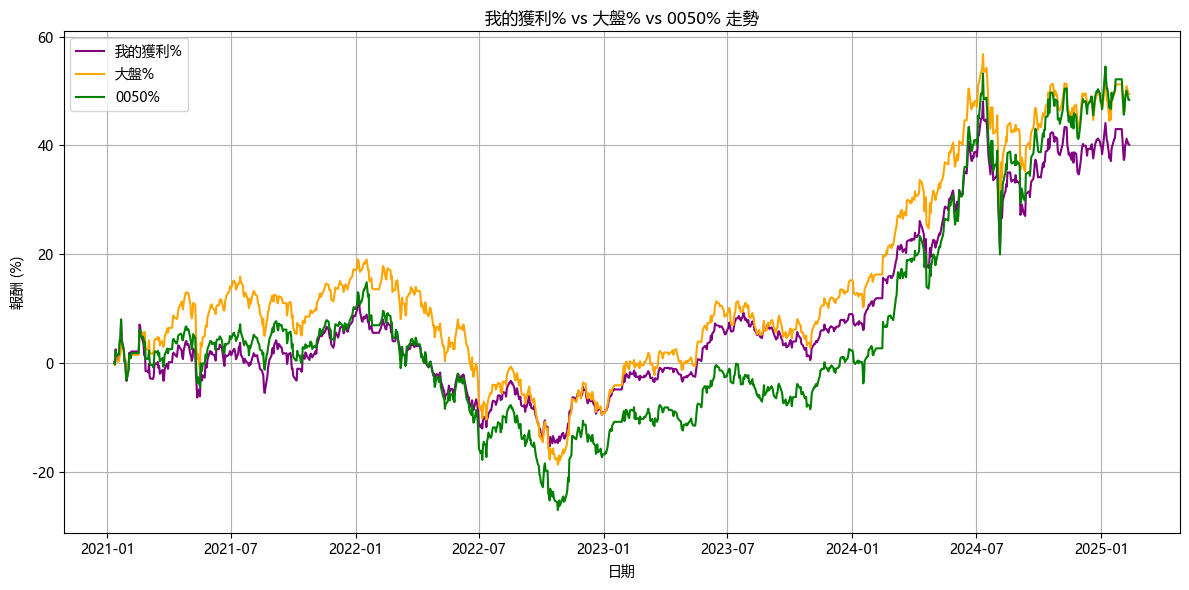

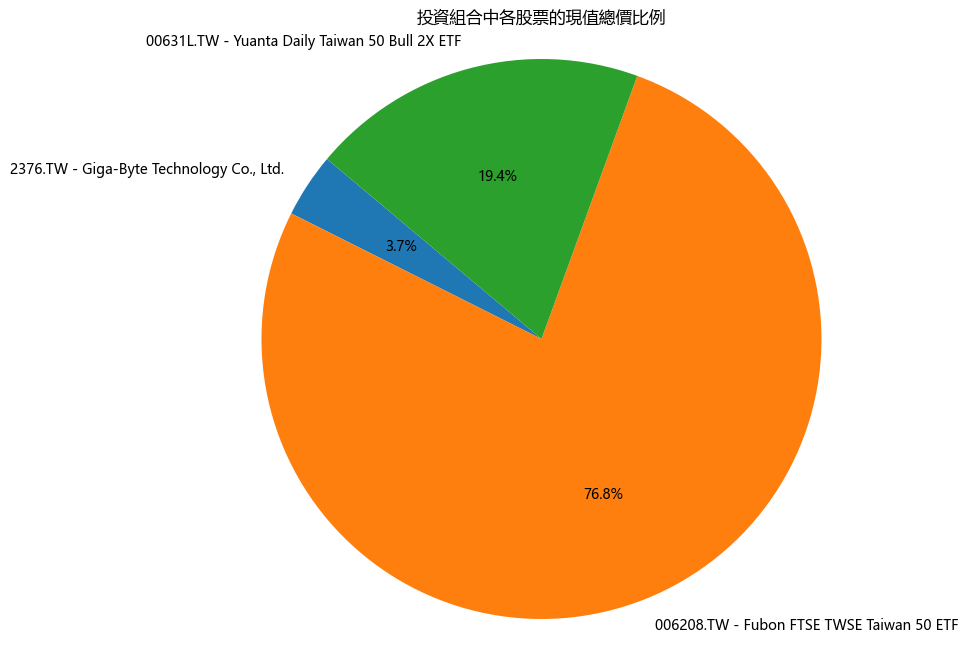


=== 總結報告 ===
總成本（累積入金）：661,551.00 元
已實現現金（賣出所得）：241,149.00 元
最終組合市值（現有持股）：685,997.89 元
總資產（已實現現金 + 組合市值）：927,146.89 元
總獲利：265,595.89 元
總獲利百分比：40.15%
XIRR: 21.53%
最終累積績效: 40.15%
每日 IRR: 0.0316%
年化 IRR: 8.30%
夏普值: 0.4518
台灣加權指數 (大盤) 夏普值: 0.5189
最大回撤: -24.32%

=== 投資組合股票明細 ===
+------------+--------------------------------------------------------------+----------+---------+------------+----------+--------------+-----------------+
| 股票代碼   | 股票名稱                                                     |   庫存股 |    股價 |   現值總價 |   總成本 |   未實現損益 |   未實現損益(%) |
|------------+--------------------------------------------------------------+----------+---------+------------+----------+--------------+-----------------|
| 0050       | 0050.TW - Yuanta/P-shares Taiwan Top 50 ETF                  |        0 |  196.3  |          0 |     -349 |        349   |       -100      |
| 2330       | 2330.TW - Taiwan Semiconductor Manufacturing Company Limited |        0 | 1105    |          0 |    -3004 |       3

In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import newton
from matplotlib import rcParams
from tabulate import tabulate  # 用來美化 DataFrame 輸出

# =============================================================================
# 全域設定：設定中文字型與正確顯示負號
# =============================================================================
rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微軟正黑體
rcParams['axes.unicode_minus'] = False


# =============================================================================
# 功能函式
# =============================================================================
def fix_share_sign(row):
    """
    若交易別為「賣」且股數為正，則將股數轉為負值
    """
    if (row['交易別'] == '賣') and (row['股數'] > 0):
        row['股數'] = -row['股數']
    return row


def get_daily_price(stock_code, start_date, end_date):
    """
    利用 yfinance 取得指定股票於指定日期區間的每日收盤價
    """
    ticker = f"{stock_code}.TW"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if data.empty:
        raise ValueError(f"無法取得 {ticker} 的資料")
    return data['Close']


def get_current_price_yf(stock_code):
    """
    利用 yfinance 取得指定股票的即時價格
    """
    ticker = f"{stock_code}.TW"
    try:
        t = yf.Ticker(ticker)
        info = t.info
        price = info.get('regularMarketPrice', None)
        if price is None:
            data = yf.download(ticker, period="1d", progress=False)
            if data.empty:
                print(f"警告: {ticker} 無法取得任何價格資料。")
                return None
            price = data['Close'].iloc[-1]
        if price == 0:
            print(f"錯誤: {ticker} 抓到的價格為 0，請檢查資料來源！")
            return None
        return price
    except Exception as e:
        print(f"取得 {ticker} 即時價格失敗，錯誤：{e}")
        return None


def xnpv(rate, cashflows):
    """
    計算不規則現金流的淨現值 (XNPV)
    """
    t0 = min(date for date, _ in cashflows)
    return sum(cf / ((1 + rate) ** ((date - t0).days / 365.0))
               for date, cf in cashflows)


def xirr(cashflows, guess=0.1):
    """
    利用牛頓法求解不規則現金流的內部報酬率 (XIRR)
    """
    return newton(lambda r: xnpv(r, cashflows), guess)


# =============================================================================
# 主程式：計算投資組合績效、繪製圖表後再顯示文字報告
# =============================================================================
def main():
    # ------------------------------
    # 1. 讀取並前置處理交易資料
    # ------------------------------
    # 請確認 CSV 檔案中有欄位：'交易日','交易別','股票代號','股數','進帳/出帳'
    df = pd.read_csv('tw_train.csv', encoding='utf-8-sig')
    df['交易日'] = pd.to_datetime(df['交易日'])
    df.sort_values('交易日', inplace=True)
    df = df.apply(fix_share_sign, axis=1)
    
    # 以最早交易日到今日建立商業日 (B) 日期範圍
    start_date = df['交易日'].min()
    end_date = pd.Timestamp.today()
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # ------------------------------
    # 2. 建立每日累積持股數與組合市值
    # ------------------------------
    pivot = df.pivot_table(index='交易日', columns='股票代號', values='股數', aggfunc='sum')
    pivot = pivot.reindex(date_range, fill_value=0).fillna(0)
    cum_holdings = pivot.cumsum()
    
    portfolio_value = pd.Series(0, index=date_range)
    for stock in cum_holdings.columns:
        try:
            s_date = date_range[0].strftime('%Y-%m-%d')
            e_date = date_range[-1].strftime('%Y-%m-%d')
            price_series = get_daily_price(stock, s_date, e_date)
            price_series = price_series.reindex(date_range).ffill()
            stock_value = cum_holdings[stock] * price_series
            portfolio_value += stock_value
        except Exception as e:
            print(f"取得股票 {stock} 價格資料失敗: {e}")
    portfolio_value = portfolio_value.ffill().bfill()
    
    # ------------------------------
    # 3. 投資績效數值計算
    # ------------------------------
    total_investment = -df[df['進帳/出帳'] < 0]['進帳/出帳'].sum()  # 累積買進金額
    realized_cash = df[df['進帳/出帳'] > 0]['進帳/出帳'].sum()       # 賣出所得
    final_portfolio_value = portfolio_value.iloc[-1]
    total_assets = final_portfolio_value + realized_cash
    total_profit = total_assets - total_investment
    total_profit_pct = (total_profit / total_investment) * 100
    
    # XIRR：現金流包含所有交易與最新組合市值（以今日為日期）
    cashflows = list(df[['交易日', '進帳/出帳']].itertuples(index=False, name=None))
    net_holdings = df.groupby('股票代號')['股數'].sum()
    portfolio_snapshot = 0
    for stock, shares in net_holdings.items():
        if shares != 0:
            price = get_current_price_yf(stock)
            if price is not None:
                portfolio_snapshot += shares * price
    today = pd.Timestamp.today().normalize()
    cashflows.append((today, portfolio_snapshot))
    
    try:
        irr = xirr(cashflows)
    except Exception as e:
        irr = None
        print("XIRR 計算失敗:", e)
    
    # 以累積買進現金流計算績效比率
    buy_flows = -df[df['進帳/出帳'] < 0].groupby('交易日')['進帳/出帳'].sum()
    buy_flows = buy_flows.reindex(date_range, fill_value=0).cumsum()
    sell_flows = df[df['進帳/出帳'] > 0].groupby('交易日')['進帳/出帳'].sum()
    sell_flows = sell_flows.reindex(date_range, fill_value=0).cumsum()
    total_wealth = portfolio_value + sell_flows
    performance_ratio = pd.Series(np.nan, index=date_range)
    mask = (buy_flows > 0)
    performance_ratio[mask] = total_wealth[mask] / buy_flows[mask]
    profit_pct = (performance_ratio - 1) * 100
    
    # IRR (幾何平均) 計算：視作累積成長因子
    wealth_factor = performance_ratio.dropna()
    if len(wealth_factor) > 0:
        daily_IRR = wealth_factor.iloc[-1] ** (1 / len(wealth_factor)) - 1
        annual_IRR = (1 + daily_IRR) ** 252 - 1
    else:
        daily_IRR = None
        annual_IRR = None
    
    # 夏普值計算：使用每日報酬率扣除無風險利率 (假設年化 2%)
    daily_return = performance_ratio.pct_change()
    annual_rf = 0.02
    daily_rf = annual_rf / 252
    excess_return = daily_return - daily_rf
    sharpe_ratio = np.sqrt(252) * (excess_return.mean() / excess_return.std())
    
    # 大盤（台灣加權指數 '^TWII'）累積漲跌幅
    s_str = date_range[0].strftime('%Y-%m-%d')
    e_str = date_range[-1].strftime('%Y-%m-%d')
    twii_data = yf.download('^TWII', start=s_str, end=e_str)
    benchmark_value = twii_data['Adj Close']
    benchmark_value = benchmark_value.reindex(date_range).ffill()
    benchmark_return = benchmark_value.pct_change().dropna()
    excess_benchmark = benchmark_return - daily_rf
    benchmark_sharpe = np.sqrt(252) * (excess_benchmark.mean() / excess_benchmark.std())
    
    # 大盤累積漲跌幅
    index_close = twii_data['Close']
    index_close = index_close.reindex(date_range).ffill()
    base_price = index_close.iloc[0]
    index_pct = (index_close / base_price - 1) * 100

    # 新增：0050（元大台灣50 ETF）累積漲跌幅比較
    etf_data = yf.download('0050.TW', start=s_str, end=e_str, progress=False)
    if not etf_data.empty:
        etf_close = etf_data['Close']
        etf_close = etf_close.reindex(date_range).ffill()
        etf_pct = (etf_close / etf_close.iloc[0] - 1) * 100
    else:
        print("無法取得 0050.TW 資料")
        etf_pct = None

    # 計算最大回撤
    # 這裡將 profit_pct 轉換為績效比率後計算回撤
    pr_for_dd = profit_pct / 100 + 1
    running_max = pr_for_dd.cummax()
    drawdown = pr_for_dd / running_max - 1
    max_drawdown = drawdown.min() * 100  # 此變數確保在後面使用時已定義

    # ------------------------------
    # 4. 整合第二段程式碼：計算個股現值與投資組合股票明細
    # ------------------------------
    stock_counts = {}
    
    def get_taiwan_stock_name(ticker_symbol):
        """利用 yfinance 取得股票中文名稱，若找不到則回傳預設值"""
        if not ticker_symbol.endswith('.TW'):
            ticker_symbol += '.TW'
        ticker = yf.Ticker(ticker_symbol)
        company_name = ticker.info.get('longName', '公司名稱未找到')
        return f"{ticker_symbol} - {company_name}"
    
    for idx, row in df.iterrows():
        stock_code = row['股票代號']
        stock_name = get_taiwan_stock_name(stock_code)
        count = row['股數']
        cost = float(row['進帳/出帳'])
        if pd.isna(stock_code) or pd.isna(count):
            continue
        if stock_code not in stock_counts:
            stock_counts[stock_code] = {'名稱': stock_name, '庫存股': 0, '總成本': 0}
        stock_counts[stock_code]['庫存股'] += count
        stock_counts[stock_code]['總成本'] += cost
    
    data_list = []
    for stock_code, data_dict in stock_counts.items():
        name = data_dict['名稱']
        count = data_dict['庫存股']
        cost = -data_dict['總成本']  # 轉為正數
        try:
            ticker = yf.Ticker(f"{stock_code}.TW")
            val = ticker.history(period='1d')['Close'].iloc[-1]
        except Exception as e:
            print(f"Error fetching data for {stock_code}: {e}")
            val = 0
        val_total = val * count
        gain = val_total - cost
        gain_per = (gain / cost) * 100 if cost != 0 else 0
        data_list.append([stock_code, name, count, val, val_total, cost, gain, gain_per])
    headers = ['股票代碼', '股票名稱', '庫存股', '股價', '現值總價', '總成本', '未實現損益', '未實現損益(%)']
    portfolio_df = pd.DataFrame(data_list, columns=headers)
    filtered_df = portfolio_df[portfolio_df['現值總價'] > 0]
    
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 0 else ''
    
    # ------------------------------
    # 5. 圖表輸出 (圖表優先顯示)
    # ------------------------------
    # (1) 組合市值走勢圖
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_value.index, portfolio_value.values, label='組合市值', color='blue')
    plt.xlabel('日期')
    plt.ylabel('組合市值')
    plt.title('每日股票組合市值')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # (2) 我的獲利% vs 大盤% vs 0050% 走勢圖
    plt.figure(figsize=(12, 6))
    plt.plot(profit_pct.index, profit_pct.values, label='我的獲利%', color='purple')
    plt.plot(index_pct.index, index_pct.values, label='大盤%', color='orange')
    if etf_pct is not None:
        plt.plot(etf_pct.index, etf_pct.values, label='0050%', color='green')
    plt.xlabel('日期')
    plt.ylabel('報酬 (%)')
    plt.title('我的獲利% vs 大盤% vs 0050% 走勢')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # (3) 投資組合中各股票現值比例圓餅圖
    plt.figure(figsize=(10, 8))
    plt.pie(filtered_df['現值總價'], 
            labels=filtered_df['股票名稱'], 
            autopct=autopct_format, 
            startangle=140)
    plt.title('投資組合中各股票的現值總價比例')
    plt.axis('equal')
    
    # 統一顯示所有圖表
    plt.show()
    
    # ------------------------------
    # 6. 文字報告 (圖表關閉後顯示)
    # ------------------------------
    print("\n=== 總結報告 ===")
    print(f"總成本（累積入金）：{total_investment:,.2f} 元")
    print(f"已實現現金（賣出所得）：{realized_cash:,.2f} 元")
    print(f"最終組合市值（現有持股）：{final_portfolio_value:,.2f} 元")
    print(f"總資產（已實現現金 + 組合市值）：{total_assets:,.2f} 元")
    print(f"總獲利：{total_profit:,.2f} 元")
    print(f"總獲利百分比：{total_profit_pct:.2f}%")
    
    if irr is not None:
        print(f"XIRR: {irr:.2%}")
    else:
        print("XIRR: 計算失敗")
    
    if daily_IRR is not None and annual_IRR is not None:
        print("最終累積績效: {:.2f}%".format((wealth_factor.iloc[-1] - 1) * 100))
        print(f"每日 IRR: {daily_IRR:.4%}")
        print(f"年化 IRR: {annual_IRR:.2%}")
    else:
        print("IRR: 無法計算")
    
    print(f"夏普值: {sharpe_ratio:.4f}")
    print(f"台灣加權指數 (大盤) 夏普值: {benchmark_sharpe:.4f}")
    print(f"最大回撤: {max_drawdown:.2f}%")
    
    # 使用 tabulate 美化輸出投資組合股票明細
    print("\n=== 投資組合股票明細 ===")
    print(tabulate(portfolio_df, headers='keys', tablefmt='psql', showindex=False))


if __name__ == '__main__':
    main()


[*********************100%***********************]  6 of 6 completed



=== 投資組合股票明細 ===
+----------+--------+----------------+----------+---------------+----------+---------+---------------+
| Symbol   | name   |   Quantity_now |    Price |   Price_Total |     cost |    gain |   gain_per(%) |
|----------+--------+----------------+----------+---------------+----------+---------+---------------|
| TQQQ     | TQQQ   |              0 |  84.895  |          0    | -3441.68 | 3441.68 |    -100       |
| EDV      | EDV    |             61 |  67.6    |       4123.6  |  4935.46 | -811.86 |     -16.4495  |
| TMF      | TMF    |              0 |  39.8485 |          0    |    42.06 |  -42.06 |    -100       |
| VOO      | VOO    |              0 | 554.83   |          0    |  -507.63 |  507.63 |    -100       |
| SPLG     | SPLG   |             95 |  70.9756 |       6742.68 |  5266.82 | 1475.86 |      28.0219  |
| QLD      | QLD    |            112 | 114.14   |      12783.7  | 12351.9  |  431.83 |       3.49607 |
+----------+--------+----------------+----------+------

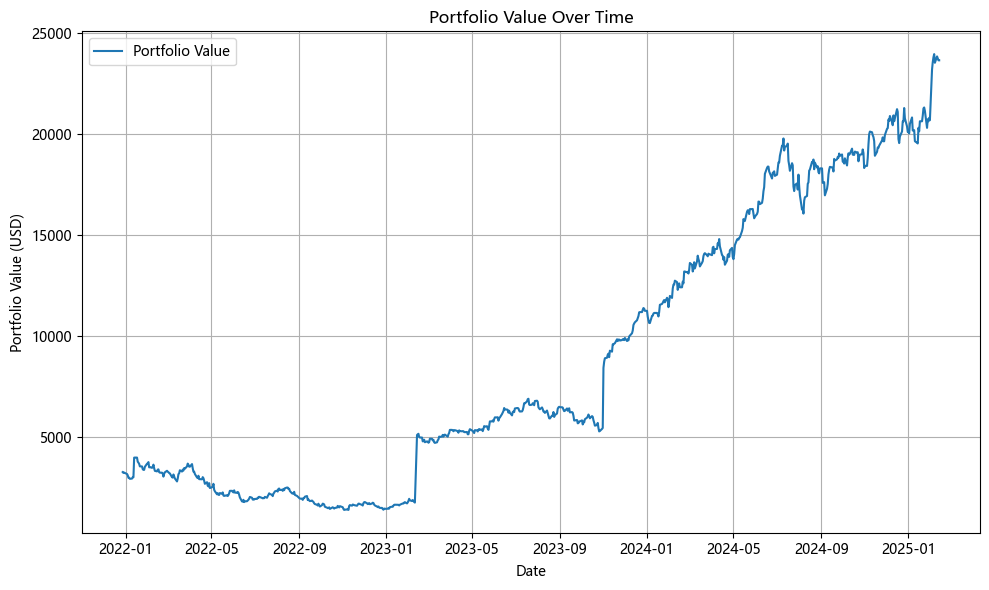

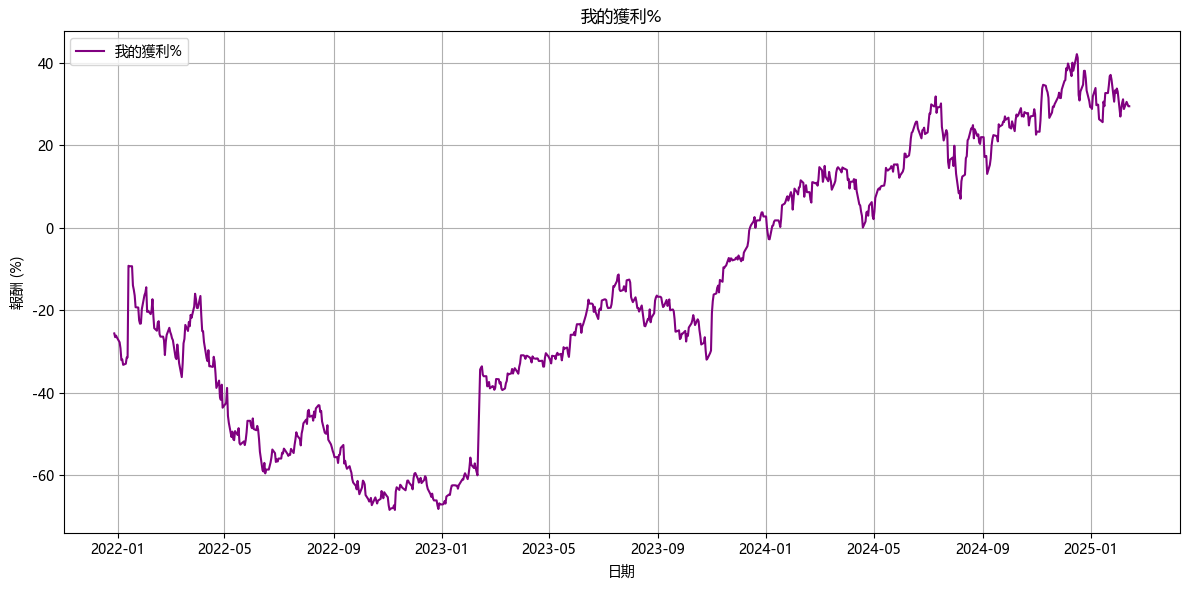

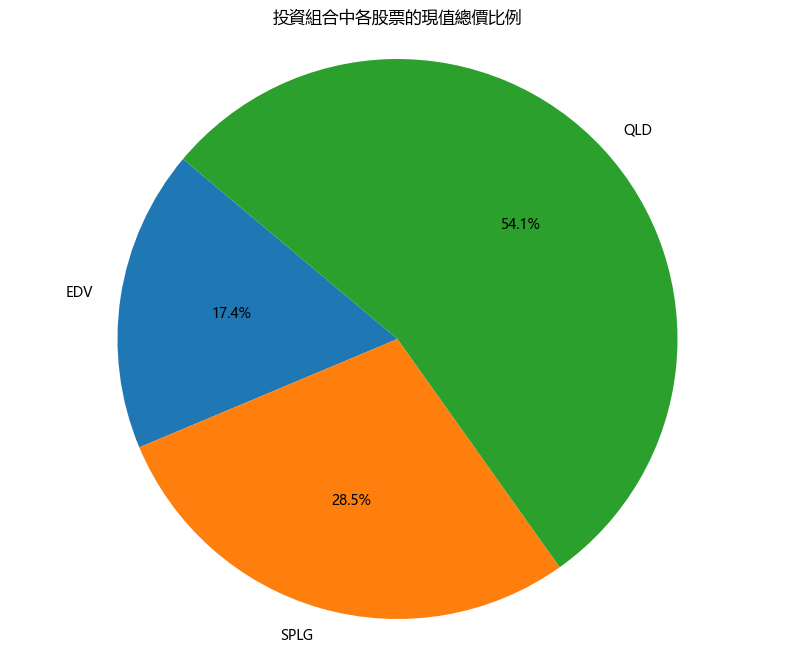

2023/2/10 到 2023/2/15 的市值:
2023-02-10    1741.006527
2023-02-13    5089.053566
2023-02-14    5123.984961
2023-02-15    5149.303875
Freq: B, dtype: float64
2023/2/10 ~ 2023/2/15 的累積買進現金流:
2023-02-10    4894.05
2023-02-11       0.00
2023-02-12       0.00
2023-02-13    9332.95
2023-02-14    9332.95
2023-02-15    9332.95
Freq: D, Name: Amount, dtype: float64

2023/2/10 ~ 2023/2/15 的累積賣出現金流:
2023-02-10     539.71
2023-02-11       0.00
2023-02-12       0.00
2023-02-13    1577.55
2023-02-14    1577.55
2023-02-15    1577.55
Freq: D, Name: Amount, dtype: float64

2023/2/10 ~ 2023/2/15 total_wealth_period:
2023-02-10   -2613.333473
2023-02-11       0.000000
2023-02-12       0.000000
2023-02-13   -2666.346434
2023-02-14   -2631.415039
2023-02-15   -2606.096125
Freq: D, dtype: float64

2023/2/10 ~ 2023/2/15 profit_pct_period:
2023-02-10   -60.016753
2023-02-11     0.000000
2023-02-12     0.000000
2023-02-13   -34.380515
2023-02-14   -33.930101
2023-02-15   -33.603633
Freq: D, dtype: float64

2023/

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import newton
from matplotlib import rcParams
from tabulate import tabulate  # 用來美化 DataFrame 輸出

# =============================================================================
# 全域設定：設定中文字型與正確顯示負號
# =============================================================================
rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微軟正黑體
rcParams['axes.unicode_minus'] = False


# =============================================================================
# 功能函式
# =============================================================================

def clean_currency(x):
    """
    清理貨幣字串，移除 '$' 與逗號，並轉換成 float。
    若轉換失敗則回傳 None。
    """
    if pd.isnull(x) or str(x).strip() == "":
        return None
    try:
        return float(str(x).replace("$", "").replace(",", "").strip())
    except Exception as e:
        print(f"轉換 {x} 失敗: {e}")
        return None


def fix_share_sign(row):
    """
    若交易別為 "Sell" 且 Quantity 為正，則將 Quantity 轉為負值
    """
    if (str(row['Action']).lower() == 'sell') and (row['Quantity'] > 0):
        row['Quantity'] = -row['Quantity']
    return row


def get_daily_price(stock_symbol, start_date, end_date):
    """
    利用 yfinance 下載指定股票（或股票列表）每日收盤價資料。
    回傳資料中的 'Close' 欄位
    """
    try:
        data = yf.download(stock_symbol, start=start_date, end=end_date)
        return data['Close']
    except Exception as e:
        print(f"下載 {stock_symbol} 價格失敗: {e}")
        return 0


def get_current_price_yf(ticker):
    """
    利用 yfinance 查詢單一股票的最新價格，
    優先從 info 取得 regularMarketPrice，若無則從 history 中取得最新收盤價
    """
    try:
        data = yf.Ticker(ticker)
        price = data.info.get("regularMarketPrice")
        if price is None:
            hist = data.history(period="1d")
            if not hist.empty:
                price = hist["Close"].iloc[-1]
        return price
    except Exception as e:
        print(f"取得 {ticker} 價格失敗: {e}")
        return None


def xnpv(rate, cashflows):
    """
    計算不規則現金流的淨現值 (XNPV)
    :param rate: 折現率
    :param cashflows: [(date, cashflow), ...]
    """
    t0 = min(date for date, _ in cashflows)
    return sum(cf / ((1 + rate) ** ((date - t0).days / 365.0))
               for date, cf in cashflows)


def xirr(cashflows, guess=0.1):
    """
    利用牛頓法求解不規則現金流的內部報酬率 (XIRR)
    :param cashflows: [(date, cashflow), ...]
    :param guess: 初始猜測值
    """
    return newton(lambda r: xnpv(r, cashflows), guess)


# =============================================================================
# 主程式：計算投資組合績效、輸出文字報告，再顯示圖表
# =============================================================================

def main():
    # ------------------------------
    # 1. 讀取並前置處理交易資料
    # ------------------------------
    # 請確認 CSV 檔案中有欄位： 'Date', 'Action', 'Symbol', 'Quantity', 'Price', 'Amount'
    # 此範例假設檔名為 'us_train.csv'
    df = pd.read_csv('us_train.csv', encoding='utf-8-sig')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df = df.apply(fix_share_sign, axis=1)
    
    # 清理貨幣字串（轉換 Amount 欄位）
    df["Amount"] = df["Amount"].apply(clean_currency)

    # 建立日期範圍（從最早交易日到今日，僅包含商業日）
    start_date = df['Date'].min()
    end_date = pd.Timestamp.today()
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # =============================================================================
    # 2. 建立每日累積持股數與組合市值
    # =============================================================================
    pivot = df.pivot_table(index='Date', columns='Symbol', values='Quantity', aggfunc='sum')
    pivot = pivot.reindex(date_range, fill_value=0).fillna(0)
    cum_holdings = pivot.cumsum()
    
    # 取得所有股票代碼
    symbols = cum_holdings.columns.tolist()
    
    # 取得各標的的每日調整後收盤價資料
    price_data = get_daily_price(symbols, start_date, end_date)
    price_data = price_data.reindex(date_range).ffill().bfill()
    
    # 計算每日投資組合市值
    portfolio_value = (cum_holdings * price_data).sum(axis=1)
    
    # 建立圖表：投資組合市值走勢
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_value.index, portfolio_value.values, label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # ※ 此處不呼叫 plt.show()，先保留圖表

    # ------------------------------
    # 3. 投資績效數值計算與文字輸出
    # ------------------------------
    total_investment = -df[df['Amount'] < 0]['Amount'].sum()  # 累積買進金額
    realized_cash = df[df['Amount'] > 0]['Amount'].sum()       # 賣出所得
    final_portfolio_value = portfolio_value.iloc[-1]
    total_assets = final_portfolio_value + realized_cash
    total_profit = total_assets - total_investment
    total_profit_pct = (total_profit / total_investment) * 100
    
    # XIRR 計算：現金流包含所有交易與最新組合市值（以今日為日期）
    cashflows = list(df[['Date', 'Amount']].itertuples(index=False, name=None))
    net_holdings = df.groupby('Symbol')['Quantity'].sum()
    portfolio_snapshot = 0
    for stock, shares in net_holdings.items():
        if shares != 0:
            price = get_current_price_yf(stock)
            if price is not None:
                portfolio_snapshot += shares * price
    today = pd.Timestamp.today().normalize()
    cashflows.append((today, portfolio_snapshot))

    try:
        irr = xirr(cashflows)
    except Exception as e:
        irr = None
        print("XIRR 計算失敗:", e)
    
    # 以累積買進現金流計算績效比率
    buy_flows = -df[df['Amount'] < 0].groupby('Date')['Amount'].sum()
    buy_flows = buy_flows.reindex(date_range, fill_value=0).cumsum()
    sell_flows = df[df['Amount'] > 0].groupby('Date')['Amount'].sum()
    sell_flows = sell_flows.reindex(date_range, fill_value=0).cumsum()
    total_wealth = portfolio_value + sell_flows - buy_flows #市值+賺的
    performance_ratio = pd.Series(np.nan, index=date_range)
    costs = buy_flows - sell_flows;#成本 = 買的 - 賣的
    #mask = (buy_flows > 0)
    #performance_ratio[mask] = total_wealth[mask] / costs[mask]

    performance_ratio = total_wealth / costs
    profit_pct = (performance_ratio) * 100
    
    # IRR (幾何平均) 計算：視作累積成長因子
    wealth_factor = performance_ratio.dropna()
    if len(wealth_factor) > 0:
        daily_IRR = wealth_factor.iloc[-1] ** (1 / len(wealth_factor)) - 1
        annual_IRR = (1 + daily_IRR) ** 252 - 1
    else:
        daily_IRR = None
        annual_IRR = None

    # 輸出績效指標
    #print("daily_IRR: " + str(daily_IRR))
    #print("annual_IRR: " + str(annual_IRR))
    
    # 夏普值計算：使用每日報酬率扣除無風險利率 (假設年化 2%)
    daily_return = performance_ratio.pct_change()
    annual_rf = 0.02
    daily_rf = annual_rf / 252
    excess_return = daily_return - daily_rf
    sharpe_ratio = np.sqrt(252) * (excess_return.mean() / excess_return.std())
    #print("sharpe_ratio: " + str(sharpe_ratio))
    
    # 計算最大回撤
    pr_for_dd = profit_pct / 100 + 1
    running_max = pr_for_dd.cummax()
    drawdown = pr_for_dd / running_max - 1
    max_drawdown = drawdown.min() * 100
    #print("max_drawdown: " + str(max_drawdown))
    
    # ------------------------------
    # 4. 整合個股現值與投資組合股票明細
    # ------------------------------
    stock_counts = {}
    
    for idx, row in df.iterrows():
        stock_code = row['Symbol']
        stock_name = stock_code  # 可依需求轉換為股票全名
        count = row['Quantity']
        cost = float(row['Amount'])
        if pd.isna(stock_code) or pd.isna(count):
            continue
        if stock_code not in stock_counts:
            stock_counts[stock_code] = {'stock_name': stock_name, 'Quantity_now': 0, 'cost': 0}
        stock_counts[stock_code]['Quantity_now'] += count
        stock_counts[stock_code]['cost'] += cost
    
    data_list = []
    for stock_code, data_dict in stock_counts.items():
        name = data_dict['stock_name']
        count = data_dict['Quantity_now']
        cost = -data_dict['cost']  # 將成本轉為正值
        try:
            ticker = yf.Ticker(stock_code)
            val = ticker.history(period='1d')['Close'].iloc[-1]
        except Exception as e:
            print(f"Error fetching data for {stock_code}: {e}")
            val = 0
        val_total = val * count
        gain = val_total - cost
        gain_per = (gain / cost) * 100 if cost != 0 else 0
        data_list.append([stock_code, name, count, val, val_total, cost, gain, gain_per])
    headers = ['Symbol', 'name', 'Quantity_now', 'Price', 'Price_Total', 'cost', 'gain', 'gain_per(%)']
    portfolio_df = pd.DataFrame(data_list, columns=headers)
    filtered_df = portfolio_df[portfolio_df['Price_Total'] > 0]
    
    # 輸出投資組合股票明細（使用 tabulate 美化）
    print("\n=== 投資組合股票明細 ===")
    print(tabulate(portfolio_df, headers='keys', tablefmt='psql', showindex=False))
    
    # 輸出總結報告
    print("\n=== 總結報告 ===")
    print(f"總成本（累積入金）：{total_investment:,.2f} 元")
    print(f"已實現現金（賣出所得）：{realized_cash:,.2f} 元")
    print(f"最終組合市值（現有持股）：{final_portfolio_value:,.2f} 元")
    print(f"總資產（已實現現金 + 組合市值）：{total_assets:,.2f} 元")
    print(f"總獲利：{total_profit:,.2f} 元")
    print(f"總獲利百分比：{total_profit_pct:.2f}%")
    
    if irr is not None:
        print(f"XIRR: {irr:.2%}")
    else:
        print("XIRR: 計算失敗")
    
    if daily_IRR is not None and annual_IRR is not None:
        print("最終累積績效: {:.2f}%".format((wealth_factor.iloc[-1] - 1) * 100))
        print(f"每日 IRR: {daily_IRR:.4%}")
        print(f"年化 IRR: {annual_IRR:.2%}")
    else:
        print("IRR: 無法計算")
    
    print(f"夏普值: {sharpe_ratio:.4f}")
    print(f"最大回撤: {max_drawdown:.2f}%")
    
    
    # ------------------------------
    # 5. 建立其他圖表（文字輸出完成後再顯示圖表）
    # ------------------------------
    # (1) 我的獲利% 圖表
    plt.figure(figsize=(12, 6))
    plt.plot(profit_pct.index, profit_pct.values, label='我的獲利%', color='purple')
    plt.xlabel('日期')
    plt.ylabel('報酬 (%)')
    plt.title('我的獲利%')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # (2) 投資組合中各股票現值比例圓餅圖
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 0 else ''
    
    plt.figure(figsize=(10, 8))
    plt.pie(filtered_df['Price_Total'], 
            labels=filtered_df['name'], 
            autopct=autopct_format, 
            startangle=140)
    plt.title('投資組合中各股票的現值總價比例')
    plt.axis('equal')
    
    # ------------------------------
    # 顯示所有圖表
    # ------------------------------
    plt.show()

    # ------------------------------
    # DEBUG
    # 設定起始與結束日期
    start_date = pd.Timestamp('2023-02-10')
    end_date = pd.Timestamp('2023-02-15')

    # 取得該日期範圍內的市值資料
    selected_values = portfolio_value.loc[start_date:end_date]

    # 輸出結果
    print("2023/2/10 到 2023/2/15 的市值:")
    print(selected_values)

    

    # 建立每日日期範圍 (使用 freq='D'，即使原本是 business days)
    query_date_range = pd.date_range(start_date, end_date, freq='D')

    # 依照此日期範圍重新取出買進、賣出現金流資料（若原本的 buy_flows, sell_flows 指標為累積值）
    buy_flows_period = buy_flows.reindex(query_date_range, fill_value=0)
    sell_flows_period = sell_flows.reindex(query_date_range, fill_value=0)
    total_wealth_period = total_wealth.reindex(query_date_range, fill_value=0)
    profit_pct_period = profit_pct.reindex(query_date_range, fill_value=0)
    costs_pct_period = costs.reindex(query_date_range, fill_value=0)
    # 印出結果
    print("2023/2/10 ~ 2023/2/15 的累積買進現金流:")
    print(buy_flows_period)

    print("\n2023/2/10 ~ 2023/2/15 的累積賣出現金流:")
    print(sell_flows_period)

    print("\n2023/2/10 ~ 2023/2/15 total_wealth_period:")
    print(total_wealth_period)

    print("\n2023/2/10 ~ 2023/2/15 profit_pct_period:")
    print(profit_pct_period)
    
    print("\n2023/2/10 ~ 2023/2/15 costs_pct_period:")
    print(costs_pct_period)

if __name__ == '__main__':
    main()
